In [1]:
# Library
import sub_class as sc
from config import *

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import os
import gc
import re
import h5py
import exchange_calendars as xcals
import random
import importlib
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

mi = pd.IndexSlice

In [2]:
importlib.reload(sc)

<module 'sub_class' from 'c:\\Users\\naniri\\Documents\\GitHub\\FinanceProject\\sub_class.py'>

In [3]:
def initialize_log_dir(base_log_dir="logs/fit"):
    if os.path.exists(base_log_dir):
        shutil.rmtree(base_log_dir)  # 기존 로그 디렉토리 삭제
    os.makedirs(base_log_dir, exist_ok=True)  # 새 디렉토리 생성
    return os.path.join(base_log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
def rate(target, flag):
    return (target-flag) / flag * 100

def minmaxscaling(targ:torch.Tensor) -> torch.Tensor:
    tensor_min, _ = torch.min(targ, dim=1, keepdim=True)
    tensor_max, _ = torch.max(targ, dim=1, keepdim=True)
    scaled_tensor = (targ - tensor_min) / (tensor_max - tensor_min)
    tensor_cleaned = torch.nan_to_num(scaled_tensor, nan=0.5, posinf=1e8, neginf=-1e8)
    return tensor_cleaned

In [5]:
class Transforms:
    @staticmethod
    def example(data, hz_patch:dict[str, int]):
        '''
        input shape: dict[str, tensor]; each tensor ~ (T, 7)
        return shape: dict[str, (abs_tensor, rel_tensor)]; tensor ~ (T-hz_patch[hz]+1, f)
        '''
        result = dict()
        for hz in THZ:
            tensor_data = torch.tensor(data[hz].to_numpy(), dtype=torch.float32)  # (T, 7)
            unfolded = tensor_data.unfold(dimension=0, size=hz_patch[hz], step=1)  # (T, 7, S)
            # (T, p)로 만들어야됨  -> vwap 그 자체 / 평균, 분산, 최대, 최소, 거래량 평균를 넣자. => p = S + 4
            pattern = unfolded[:, 5]
            scaled_pattern = minmaxscaling(pattern)

            pattern_features = list()
            pattern_features.append(torch.std(pattern, axis=1, keepdim=True) * 1000 / torch.mean(pattern, axis=1, keepdim=True))
            pattern_features = torch.cat(pattern_features, dim=1)
            
            nonrel_features = torch.cat([scaled_pattern, pattern_features], dim=1)

            relative_features = list()
            relative_features.append(torch.mean(unfolded[:, 5], axis=1, keepdim=True))
            relative_features.append(torch.min(unfolded[:, 2], axis=1, keepdim=True)[0])
            relative_features.append(torch.max(unfolded[:, 1], axis=1, keepdim=True)[0])
            relative_features = torch.cat(relative_features, dim=1)
            
            # padding
            rel_pad = torch.zeros(size=(hz_patch[hz]-1, relative_features.shape[1]))
            relative_features = torch.cat([rel_pad, relative_features], dim=0)
            nonrel_pad = torch.zeros(size=(hz_patch[hz]-1, nonrel_features.shape[1]))
            nonrel_features = torch.cat([nonrel_pad, nonrel_features], dim=0)
            
            result[hz] = (nonrel_features, relative_features)
        
        return result
    
    @staticmethod
    def yexample(data, label_peroid:int):
        '''
        input shape: tensor ~ (T, 7)
        return shape: tensor ~ (T-label_peroid,)
        '''
        tensor_data = torch.tensor(data.to_numpy(), dtype=torch.float32)  # (T, 7)
        unfolded = tensor_data.unfold(dimension=0, size=label_peroid, step=1)  # (T, 7, label_peroid)
        flag = tensor_data[:unfolded.shape[0]-1, 3].view(-1, 1, 1)
        
        rel = torch.divide(unfolded[1:, :4] - flag, flag) * 100  # t에 대한 t+1 ~ t+lp가 y이므로 1번 인덱스부터 사용됨 
        # average of mean, min, max
        result = torch.div(torch.min(rel[:, 2], dim=1)[0] + torch.max(rel[:, 1], dim=1)[0] + torch.mean(rel[:, 3], dim=1), 3)
        
        return result
    
    @staticmethod
    def get_ymask(data, label_hz, hz_patch, label_peroid, data_min_interval, label_density):
        '''
        input shape: tensor ~ (T, 7) for label_hz
        output shape: tensor ~ (T, 1)
        '''
        # 조건1: data_min_interval보다 긴 데이터 필요
        # 조건2: label_peroid 구간에 대해 label_hz에 데이터 존재
        targ = data['open']
        later_index = targ.index + TO_TIMEDELTA[label_hz](label_peroid)
        locations = targ.index.asof_locs(later_index, np.ones(len(later_index), dtype=bool))
        y_mask = (locations - np.array(range(len(later_index)))) >= label_peroid*label_density
        y_mask = y_mask & (targ.index >= targ.index[0] + data_min_interval) \
            & (targ.index <= targ.index[-(hz_patch[label_hz]+label_peroid)])
        
        return y_mask
    
    @staticmethod
    def get_sample(data, x, y, ymask, label_hz, hz_patch, hz_window):
        curidx = {hz:0 for hz in THZ}
        for idx, yt in enumerate(data[label_hz].index):
            # ymask check
            if not ymask[idx]: continue
            
            # curidx
            for hz in THZ:
                while True:
                    if data[hz].index[curidx[hz]] + TO_TIMEDELTA[hz](1) - timedelta(minutes=1) > yt:
                        break
                    else: curidx[hz] += 1
            if curidx[label_hz] == 0: continue
            
            # sample
            x_sample = [dict(), dict()]
            for hz in THZ:
                for rel in [0, 1]:
                    x_st = curidx[hz] - hz_window[hz]
                    if curidx[hz] == 0:
                        # no data -> zeros
                        x_sample[rel][hz] = torch.zeros((hz_window[hz], x[hz][rel].shape[1]))
                        continue
                    #
                    if x_st < 0:
                        # padding
                        pad_size = (0, 0, -x_st, 0)
                        x_sample[rel][hz] = nn.functional.pad(x[hz][rel][:curidx[hz]], pad_size, 'constant', 0)
                    else:
                        # slicing
                        x_sample[rel][hz] = x[hz][rel][x_st:curidx[hz]]
                    #
                    if rel:
                        # relative features
                        flag = data[hz].iat[curidx[hz]-1, 3]
                        x_sample[rel][hz] = torch.divide(x_sample[rel][hz] - flag, flag) * 100
                        x_sample[rel][hz][x_sample[rel][hz] == -100] = 0

            # concat rel & non-rel
            temp = dict()
            for hz in THZ:
                temp[hz] = torch.cat([x_sample[0][hz], x_sample[1][hz]], dim=1)
                
            x_sample = temp
            y_sample = y[curidx[label_hz]-1]
            yield (x_sample, y_sample)

In [6]:
class StockDatasetIter(IterableDataset):
    '''
    dataset: 불러온 차트 데이터셋
    hz_window: 각 데이터 샘플에서 참고할 lookback window의 기간(int)
    hz_patch: dataset에서 데이터포인트를 만들 때, patch를 나누는 기간(int)
    label_peroid: label을 만들 때, 데이터를 참고할 기간(int)
    data_min_interval: 최소한의 참고할 기간(delta), less than max(hz_window)
    label_hz: label을 만들 때의 시간 단위(str)
    transform, target_transform: (function)
    condition: 기타 조건
    '''
    def __init__(self, dataset:sc.StockDatasetHDF5, hz_window:dict[str,int], hz_patch:dict[str,int],
                 label_peroid:int, data_min_interval:timedelta, label_hz:str, label_density:float,
                 transform, target_transform, condition=None):
        super().__init__()
        #
        self.dataset = dataset
        self.hz_window = hz_window
        self.label_peroid = label_peroid
        self.data_min_interval = data_min_interval
        self.hz_patch = hz_patch
        self.label_hz = label_hz
        self.label_density = label_density
        self.condition = condition
        self.transform = transform
        self.target_transform = target_transform
        
    def __iter__(self):
        for data in self.dataset:
            x = self.transform(data, self.hz_patch)
            y = self.target_transform(data[self.label_hz], self.label_peroid)
            ymask = Transforms.get_ymask(data[self.label_hz], self.label_hz, self.hz_patch, self.label_peroid, self.data_min_interval,
                                         self.label_density)
            gen = Transforms.get_sample(data, x, y, ymask, self.label_hz, self.hz_patch, self.hz_window)
            
            print(f"for ticker: {data['ticker']}")
            for result in gen:
                yield result
                

In [7]:
class SampleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SampleModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.lgl = nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            torch.nn.Linear(hidden_size, output_size)
        )
        self.tanh = nn.Tanh()
        self.sig = nn.Sigmoid()

    def forward(self, x:torch.Tensor):
        # Initialize hidden and cell states
        # x = x['5m']
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the last time step
        res = self.lgl(out[:, -1, :])
        res = self.sig(res)
        return res

In [8]:
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        self.CHARGE_RATE = 0.25
        
    def forward(self, predictions, targets):
        charge = predictions * self.CHARGE_RATE
        return torch.sum(-predictions * targets) + torch.sum(charge)

In [72]:
hdf5_train = sc.StockDatasetHDF5(
    ticker_list=[
    'AAPL',  # Apple Inc.
    'MSFT',  # Microsoft Corporation
    'GOOGL', # Alphabet Inc. (Google)
    'META',  # Meta Platforms, Inc. (Facebook)
    'IBM',   # International Business Machines Corporation
    'INTC',  # Intel Corporation
    # 'CSCO',  # Cisco Systems, Inc.
    # 'ORCL',  # Oracle Corporation
    # 'HPQ',   # HP Inc.
    # 'DELL',  # Dell Technologies Inc.
    # 'QCOM',  # Qualcomm Incorporated
    # 'TXN',   # Texas Instruments Incorporated
    # 'ADBE',  # Adobe Inc.
    # 'NVDA',  # NVIDIA Corporation
    # 'CRM',   # Salesforce, Inc.
    # 'PYPL'   # PayPal Holdings, Inc.
],
    date_range=[ST, ED]
)
hdf5_valid = sc.StockDatasetHDF5(
    ticker_list=['AMZN'],
    date_range=[ST, ST+timedelta(weeks=4)]
)
hz_window = {k:v for k, v in zip(THZ,
                [100,1,1,1,1])}
hz_patch = {k:5 for k in THZ}
data_min_interval = timedelta(minutes=100)
label_peroid = 10
label_hz = '5m'
label_density = 1.0
batch_size = 64

dataset = StockDatasetIter(hdf5_train, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
val_dataset = StockDatasetIter(hdf5_valid, hz_window, hz_patch, label_peroid, data_min_interval, label_hz, label_density,
                           Transforms.example, Transforms.yexample)
dataloader = DataLoader(dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 9  # 9 channels
hidden_size = 64
output_size = 1
num_layers = 2
model = SampleModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = MyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [76]:
initial_dir = initialize_log_dir()
record_flag = 2048

# -------------------------------------

epochs = 1

# For recording
outputs_by_epochs = [[] for _ in range(epochs)]

for epoch in range(epochs):
    model.train()  # ------------------
    
    _record_cnt = 0
    _epoch_loss = 0.0
    writer = SummaryWriter(initial_dir+f'_train_{epoch}')
    
    _record_results = []
    _temp_for_loss = 0
    _batch = 0
    
    for batch_data, batch_labels in dataloader:
        batch_labels = batch_labels.reshape(-1, 1).to(device)
        batch_data = batch_data['1m'].to(device)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        
        _epoch_loss += loss.item()
        
        _temp_for_loss += loss.item()
        if batch_size * _batch >= record_flag:
            writer.add_scalar(f"Loss/train", _temp_for_loss, _record_cnt)
            _record_cnt += 1
            _temp_for_loss = 0
        _record_results.append((outputs, batch_labels))
            
        _batch += 1
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {_epoch_loss:.7f}")
    
    model.eval()  # ------------------

    _val_record_cnt = 0
    _val_epoch_loss = 0.0
    val_writer = SummaryWriter(initial_dir+f'_valid_{epoch}')

    val_data_size = 0
    with torch.no_grad():
        for val_data, val_labels in val_dataloader:
            val_labels = val_labels.reshape(-1, 1).to(device)
            val_data = val_data['1m'].to(device)
            
            val_outputs = model(val_data)
            val_loss = criterion(val_outputs, val_labels)
            _val_epoch_loss += criterion(val_outputs, val_labels).item()
            val_data_size += len(batch_labels)
            
            val_writer.add_scalar(f"Loss/valid", val_loss, _val_record_cnt)
            _val_record_cnt += 1

    print(f"Validation Loss: {_val_epoch_loss:.7f}")

for ticker: AAPL
for ticker: MSFT
for ticker: GOOGL
for ticker: META
for ticker: IBM
for ticker: INTC
Epoch [1/1], Loss: -3329.9017501


RuntimeError: maximum size for tensor at dimension 0 is 2 but size is 5

In [77]:
cpu_result = []
for r in _record_results:
    cpu_result.append((r[0].cpu().detach().numpy().flatten(), r[1].cpu().detach().numpy().flatten()))

In [78]:
l = []
for i in range(len(cpu_result)):
    r = cpu_result[i]
    top_indices = np.argsort(r[0])[-10:][::-1]
    pr, tr = r[0][top_indices], r[1][top_indices]
    l.append(np.sum(pr*tr))

In [79]:
len(l)

14015

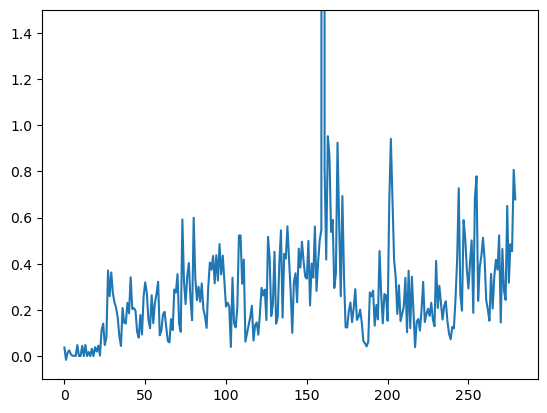

In [81]:
ax = sns.lineplot(np.array(l)[:14000].reshape(-1, 50).mean(axis=1))
ax.set_ybound(-0.1, 1.5)

In [64]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Params: {param.numel()}")

Layer: lstm.weight_ih_l0 | Size: torch.Size([256, 9]) | Params: 2304
Layer: lstm.weight_hh_l0 | Size: torch.Size([256, 64]) | Params: 16384
Layer: lstm.bias_ih_l0 | Size: torch.Size([256]) | Params: 256
Layer: lstm.bias_hh_l0 | Size: torch.Size([256]) | Params: 256
Layer: lstm.weight_ih_l1 | Size: torch.Size([256, 64]) | Params: 16384
Layer: lstm.weight_hh_l1 | Size: torch.Size([256, 64]) | Params: 16384
Layer: lstm.bias_ih_l1 | Size: torch.Size([256]) | Params: 256
Layer: lstm.bias_hh_l1 | Size: torch.Size([256]) | Params: 256
Layer: fc.weight | Size: torch.Size([1, 64]) | Params: 64
Layer: fc.bias | Size: torch.Size([1]) | Params: 1
Layer: lgl.0.weight | Size: torch.Size([64, 64]) | Params: 4096
Layer: lgl.0.bias | Size: torch.Size([64]) | Params: 64
Layer: lgl.2.weight | Size: torch.Size([1, 64]) | Params: 64
Layer: lgl.2.bias | Size: torch.Size([1]) | Params: 1


In [ ]:
# nan check
i = 0
for batch_data, batch_labels in dataloader: 
    for hz in THZ:
        if torch.isnan(batch_data[hz][0]).any() or torch.isinf(batch_data[hz][0]).any():
            print("NaN or Inf in inputs detected")
            i = 1; break
        if torch.isnan(batch_data[hz][1]).any() or torch.isinf(batch_data[hz][1]).any():
            print("NaN or Inf in labels detected")
            i = 1; break
            
    if i: break

### Test Area

In [97]:
dataset = sc.StockDatasetHDF5(
    ticker_list=['AAPL', 'MSFT'],
    date_range=[ST, ST+timedelta(days=49)]
)
hz_window = {k:v for k, v in zip(THZ,
                [3,4,5,6,7])}
hz_patch = {k:5 for k in THZ}
data_min_interval = timedelta(days=7)
label_peroid = 10
label_hz = '30m'
label_density = 0

In [98]:
data = dataset[0]

In [99]:
x = Transforms.example(data, hz_patch)
for k in x.keys():
    print(x[k][0].shape)
y = Transforms.yexample(data[label_hz], label_peroid)
print(y.shape)
ym = Transforms.get_ymask(data[label_hz], label_hz, hz_patch, label_peroid, data_min_interval, label_density)
print(ym.shape)

torch.Size([12480, 6])
torch.Size([2496, 6])
torch.Size([416, 6])
torch.Size([33, 6])
torch.Size([8, 6])
torch.Size([406])
(416,)


---

In [117]:
samples = []
curidx = {hz:0 for hz in THZ}
for idx, yt in enumerate(tqdm(data[label_hz].index)):
    # ymask check
    if not ym[idx]: continue
    
    # curidx
    for hz in THZ:
        while True:
            if data[hz].index[curidx[hz]] + TO_TIMEDELTA[hz](1) - timedelta(minutes=1) > yt:
                break
            else: curidx[hz] += 1
    if curidx[label_hz] == 0: continue
    
    if not samples: 
        print(curidx)
        for hz in THZ:
            print(data[hz].index[curidx[hz]])
    
    # sample
    x_sample = [dict(), dict()]
    for hz in THZ:
        for rel in [0, 1]:
            x_st = curidx[hz] - hz_window[hz]
            if curidx[hz] == 0:
                # no data -> zeros
                x_sample[rel][hz] = torch.zeros((hz_window[hz], x[hz][rel].shape[1]))
                continue
            #
            if x_st < 0:
                # padding
                pad_size = (0, 0, -x_st, 0)
                x_sample[rel][hz] = nn.functional.pad(x[hz][rel][:curidx[hz]], pad_size, 'constant', 0)
            else:
                # slicing
                x_sample[rel][hz] = x[hz][rel][x_st:curidx[hz]]
            #
            if rel:
                # relative features
                flag = data[hz].iat[curidx[hz]-1, 3]
                x_sample[rel][hz] = torch.divide(x_sample[rel][hz] - flag, flag) * 100
                x_sample[rel][hz][x_sample[rel][hz] == -100] = 0

    # concat rel & non-rel
    temp = dict()
    for hz in THZ:
        temp[hz] = torch.cat([x_sample[0][hz], x_sample[1][hz]], dim=1)
        
    x_sample = temp
    y_sample = y[curidx[label_hz]-1]
    samples.append([x_sample, y_sample, curidx[label_hz]])
    

  0%|          | 0/416 [00:00<?, ?it/s]

 25%|██▍       | 102/416 [00:00<00:00, 1012.60it/s]

{'1m': 1951, '5m': 390, '30m': 65, '1d': 5, '1w': 1}
2015-01-09 09:31:00
2015-01-09 09:30:00
2015-01-09 09:30:00
2015-01-09 00:00:00
2015-01-05 00:00:00


100%|██████████| 416/416 [00:00<00:00, 772.59it/s] 


In [116]:
shape_set = {hz:set() for hz in THZ}
for sam in samples:
    temp = sam[0]
    for hz in THZ:
        shape_set[hz].add(temp[hz].shape)
    # if temp.shape == torch.Size([4, 9]): print(temp)
    
shape_set

{'1m': {torch.Size([3, 9])},
 '5m': {torch.Size([4, 9])},
 '30m': {torch.Size([5, 9])},
 '1d': {torch.Size([6, 9])},
 '1w': {torch.Size([7, 9])}}